In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
import numpy as np
sys.path.insert(0, os.path.realpath(os.path.join(os.getcwd(), '..')))
from getdist import plots, loadMCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))


#-------self biuld function----------#
from function import load_covariance_matrices

GetDist Version: 1.6.4, Matplotlib version: 3.5.3


In [3]:
samples  = loadMCSamples('./cocoa/Cocoa/projects/lsst_y1/chains/EXAMPLE_MCMC4', settings = {'ignore_rows':0.3})
#samples2 = loadMCSamples('./chain_desy3_and_kids1000_hybrid_analysis.txt', settings = {'ignore_rows':0.3})
raw_samples = samples.samples
logpost = samples.weights * samples.loglikes
max_idx = np.argmax(logpost)
best_fit_params = raw_samples[max_idx]

param_names = samples.getParamNames().names


print('The best fit point from chain:')
for name, val in zip(param_names, best_fit_params):
    print(f"{name.name}: {val}")

The best fit point from chain:
As_1e9: 2.0843481
ns: 0.98203647
H0: 62.698706
omegab: 0.033638073
omegam: 0.30329146
w: -0.97988531
LSST_DZ_S1: 0.04180968
LSST_DZ_S2: 0.0080718415
LSST_DZ_S3: 0.02637681
LSST_DZ_S4: -0.079747803
LSST_DZ_S5: -0.0011711291
LSST_A1_1: 0.54295543
LSST_A1_2: -2.2451883
LSST_M1: 0.026415125
LSST_M2: -0.051529725
LSST_M3: -0.030281587
LSST_M4: -0.021131588
LSST_M5: -0.017945674
LSST_DZ_L1: 0.008351364
LSST_DZ_L2: 0.0055820197
LSST_DZ_L3: 0.018374345
LSST_DZ_L4: -0.0034546491
LSST_DZ_L5: -0.012054153
LSST_B1_1: 1.7975855
LSST_B1_2: 1.6596597
LSST_B1_3: 1.7019445
LSST_B1_4: 1.9511023
LSST_B1_5: 2.252226
As: 2.0843481e-09
omegabh2: 0.013223556
omegach2: 0.10535905
omegal: 0.69661731
omegamh2: 0.11922775
sigma8: 0.7936117
s8h5: 1.0022562
s8omegamp5: 0.43705707
s8omegamp25: 0.58894279
age: 14.936261
rdrag: 163.394
yheused: 0.24054887
omegan: 0.0016404111
minuslogprior: -48.534438
minuslogprior__0: -48.534438
chi2: 44.058754
chi2__lsst_y1.lsst_y1_3x2pt: 44.058754


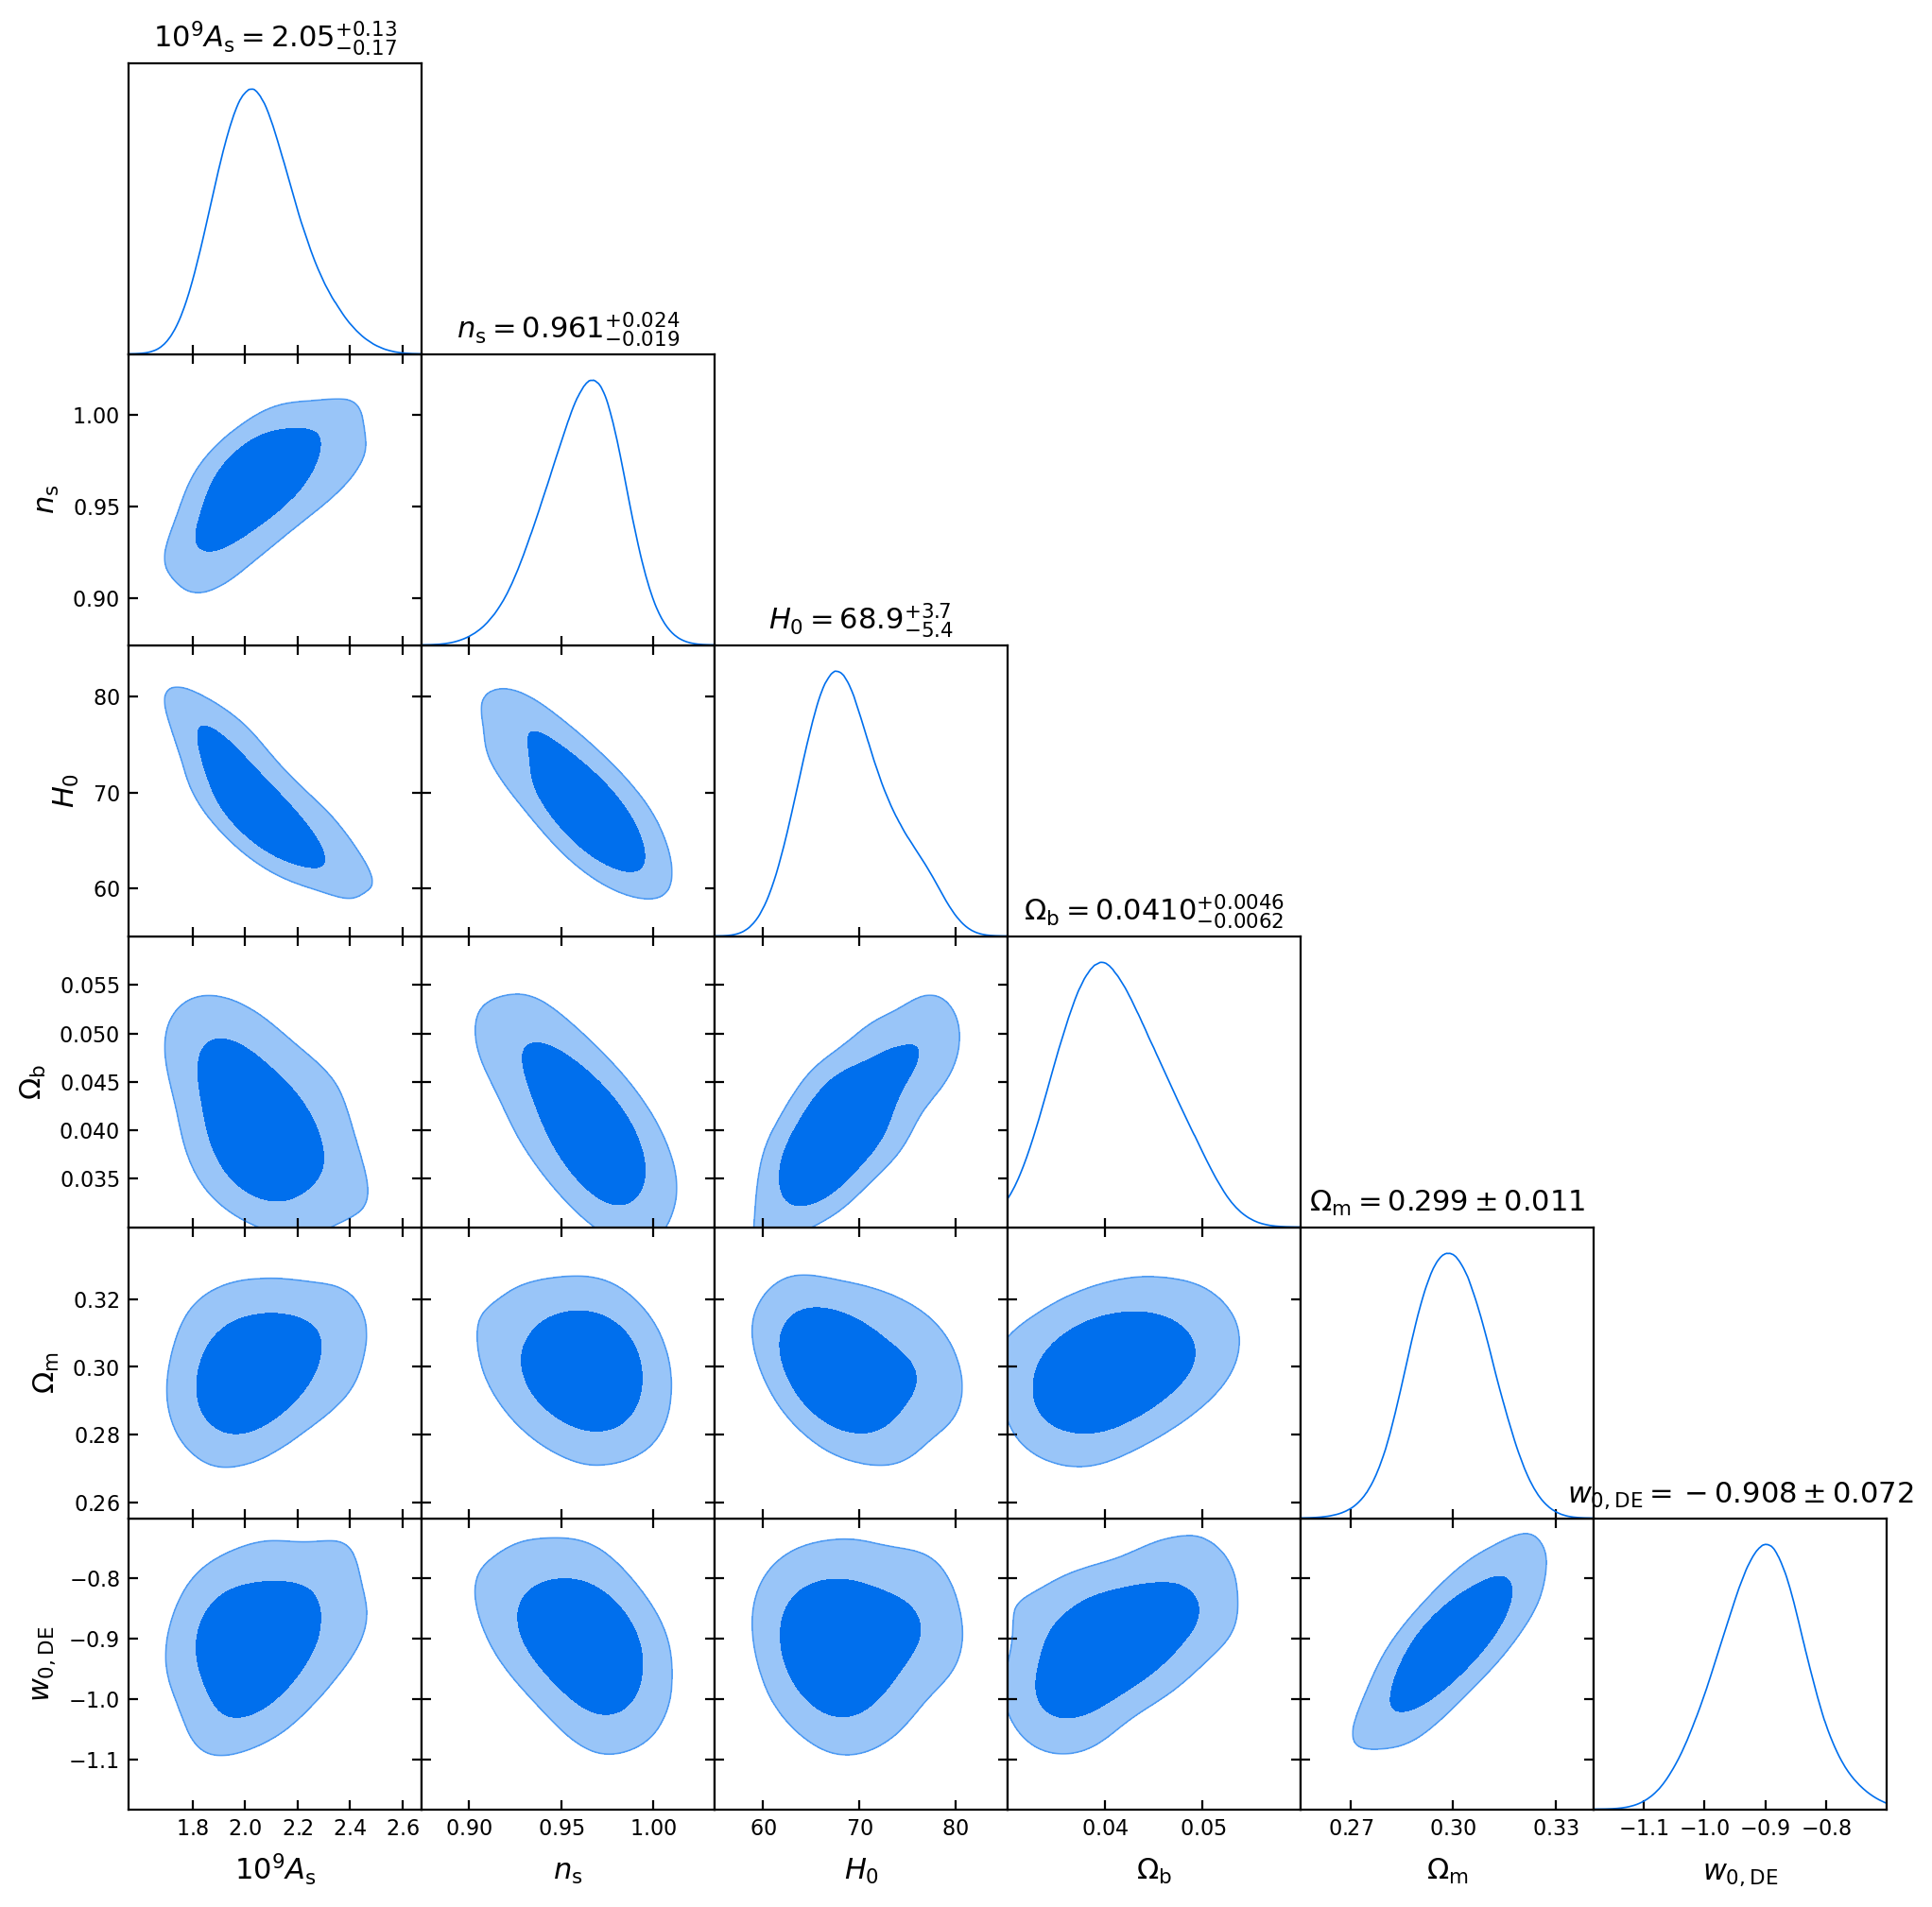

In [4]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize=14
g.triangle_plot(samples, params = [samples.getParamNames().names[i] for i in range(6)], filled=True, title_limit=1)

In [5]:
model_datavector = np.loadtxt('./cocoa/Cocoa/projects/lsst_y1/chains/lsst_y1_theory_EXAMPLE_MCMC4.modelvector')[:,1]
unmasked_model_datavector = np.loadtxt('./cocoa/Cocoa/projects/lsst_y1/chains/lsst_y1_theory_EXAMPLE_MCMC4_unmasked.modelvector')[:,1]
obs_datavector = np.loadtxt('./cocoa/Cocoa/projects/lsst_y1/data/lsst_y1_theory.modelvector')[:,1]
C_1, C_2 = load_covariance_matrices('./cocoa/Cocoa/projects/lsst_y1/data/lsst_y1_cov')

In [6]:
import itertools
from itertools import combinations_with_replacement

def plot_triangle_observable(observable_name, flat_data,
                              zbin_pairs, n_theta=26,
                              theta_min=2.5, theta_max=900.0,
                              obs_flat_data=None,
                              cov_data = None,
                              savefile=None):
    """
    Plot a triangular matrix of observable curves by redshift bin pairs.

    Supports optional observational data overlay and residual panels:
      - model curves (blue)
      - observational curves (black solid line) if obs_flat_data provided
      - residual subplot below each panel showing (model - obs) vs theta

    Uses constrained_layout for proper spacing with inset axes.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import ticker
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    expected_length = len(zbin_pairs) * n_theta
    if len(flat_data) != expected_length:
        raise ValueError(f"Expected flat_data of length {expected_length}, got {len(flat_data)}")
    if obs_flat_data is not None and len(obs_flat_data) != expected_length:
        raise ValueError(f"Expected obs_flat_data of length {expected_length}, got {len(obs_flat_data)}")

    n_tomo = max(max(i, j) for i, j in zbin_pairs) + 1
    theta = np.logspace(np.log10(theta_min), np.log10(theta_max), n_theta)

    # Use constrained_layout to handle insets and suptitle spacing
    fig, axes = plt.subplots(n_tomo, n_tomo,
                             figsize=(14, 14), sharex=True, sharey=True,
                             constrained_layout=True)
    fig.suptitle(f"{observable_name} vs θ for redshift bin pairs", fontsize=16)
    # Adjust top to make room for suptitle
    fig.subplots_adjust(top=0.92)

    for idx, (i, j) in enumerate(zbin_pairs):
        y_model = flat_data[idx * n_theta:(idx + 1) * n_theta]
        if len(y_model) != n_theta:
            axes[j, i].axis("off")
            continue

        ax = axes[j, i]
        # Plot model
        ax.plot(theta, y_model * 1e4, '*',label='model')

        # Overlay observational data
        if obs_flat_data is not None:
            y_obs = obs_flat_data[idx * n_theta:(idx + 1) * n_theta]
            ax.plot(theta, y_obs * 1e4, 'k-', label='obs')

        # Legend
        if obs_flat_data is not None:
            ax.legend(loc='best', fontsize=6, frameon=False)

        # Axis scales and formatting
        ax.set_xscale("log")
        ax.set_yscale("symlog", linthresh=1e-2)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.yaxis.set_minor_formatter(ticker.NullFormatter())
        ax.grid(True, which='both', ls='--', lw=0.3)

        # Labels on edges
        if j == n_tomo - 1:
            ax.set_xlabel(r"$\theta$ [arcmin]")
        if i == 0:
            ax.set_ylabel(rf"{observable_name} [$\times 10^4$]")

        # Bin-pair annotation
        ax.text(0.05, 0.95, f"({i},{j})", transform=ax.transAxes,
                ha='left', va='top', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))

        # Add residual inset axes if observational data provided
        if obs_flat_data is not None:
            cov = cov_data[idx * n_theta:(idx + 1) * n_theta, idx * n_theta:(idx + 1) * n_theta]
            resid = (y_model - y_obs) * 1e4 / np.sqrt(np.diag(cov))
            ax_res = inset_axes(ax, width="100%", height="25%",
                                loc='lower center', bbox_to_anchor=(0, -0.2, 1, 1),
                                bbox_transform=ax.transAxes)
            ax_res.plot(theta, resid, '.-')
            ax_res.axhline(0, color='gray', lw=0.5)
            ax_res.set_xscale('log')
            #ax_res.set_yscale('symlog')
            # Show residual y-ticks and label
            ax_res.set_ylabel('Residual', fontsize=6)
            ax_res.tick_params(axis='y', labelsize=6)
            # Only show x-ticks on bottom row insets
            if j < n_tomo - 1:
                ax_res.set_xticklabels([])

    # Hide lower triangle
    for ii in range(n_tomo):
        for jj in range(n_tomo):
            if ii > jj:
                axes[jj, ii].axis("off")

    # Save or show
    if savefile:
        fig.savefig(savefile, dpi=150)
        plt.close(fig)
    else:
        plt.show()


def plot_all_observables_triangle(datavector,
                                       obs_datavector=None,
                                       C_1 = None,
                                       C_2 = None,
                                       ntomo=5,
                                       n_theta=26,
                                       theta_min=2.5,
                                       theta_max=900.0,
                                       save=False):
    """
    Plot triangle matrix of all four observables (xi+, xi-, gammat, wtheta) from the 1560-length datavector,
    with optional observational datavector overlay and residual panels.
    """
    import matplotlib.pyplot as plt
    from itertools import combinations_with_replacement

    assert len(datavector) == 1560, "Expected datavector of length 1560"
    if obs_datavector is not None and len(obs_datavector) != 1560:
        raise ValueError(f"Expected obs_datavector of length 1560, got {len(obs_datavector)}")

    # Define 15 z-bin pairs
    zbin_pairs = list(combinations_with_replacement(range(ntomo), 2))
    len_each = len(zbin_pairs) * n_theta  # 15 × 26 = 390

    # Slice the model and observational segments
    start = 0
    segments = {}
    obs_segments = {} if obs_datavector is not None else None
    cov_segments = {} if obs_datavector is not None else None
    for obs in ["xi+", "xi-", "gxgamma", "gxg"]:
        segments[obs] = datavector[start:start + len_each]
        if obs_datavector is not None:
            obs_segments[obs] = obs_datavector[start:start + len_each]
            cov_segments[obs] = C_1[start:start + len_each,start:start + len_each] + C_2[start:start + len_each,start:start + len_each]
        start += len_each

    # Plot each observable
    for obs_name, flat_data in segments.items():
        filename = f"{obs_name}_triangle.png" if save else None
        obs_data = obs_segments.get(obs_name) if obs_segments else None
        cov_data = cov_segments.get(obs_name) if obs_segments else None
        plot_triangle_observable(
            observable_name=obs_name,
            flat_data=flat_data,
            zbin_pairs=zbin_pairs,
            n_theta=n_theta,
            theta_min=theta_min,
            theta_max=theta_max,
            obs_flat_data=obs_data,
            cov_data = cov_data,
            savefile=filename
        )


/home/junzhou/ipykernel_459486/2546172915.py:40: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(top=0.92)


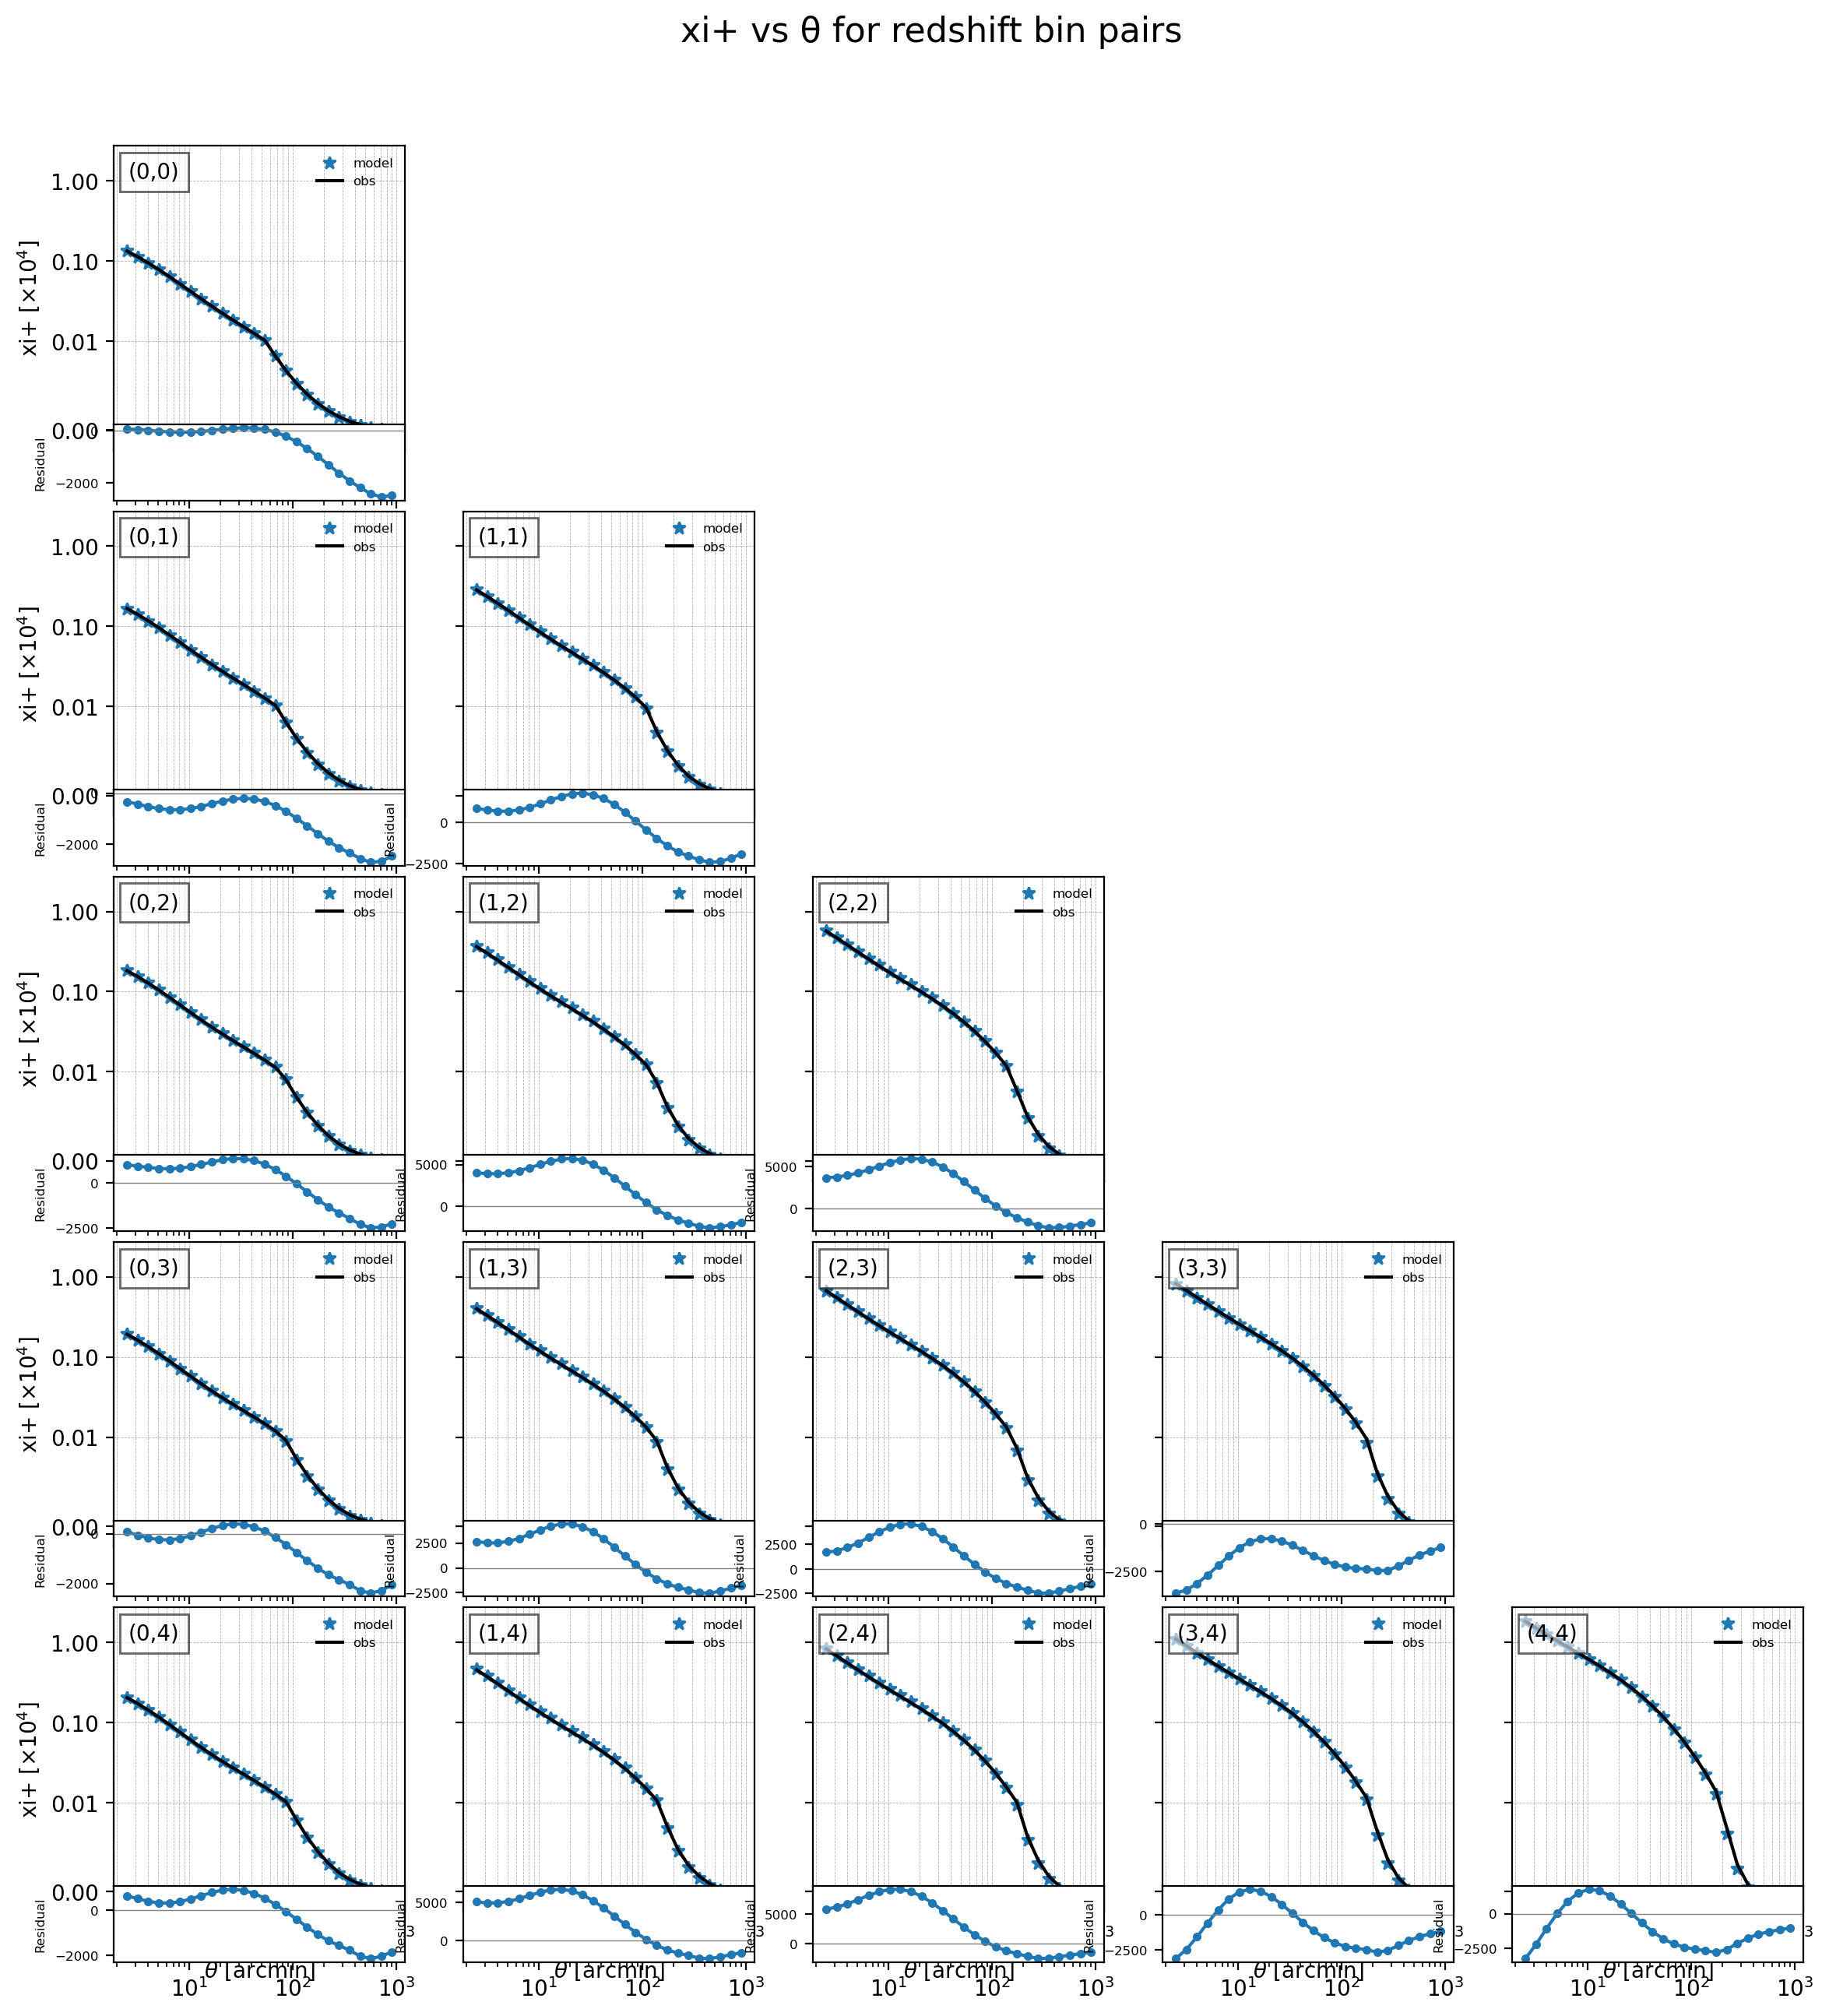

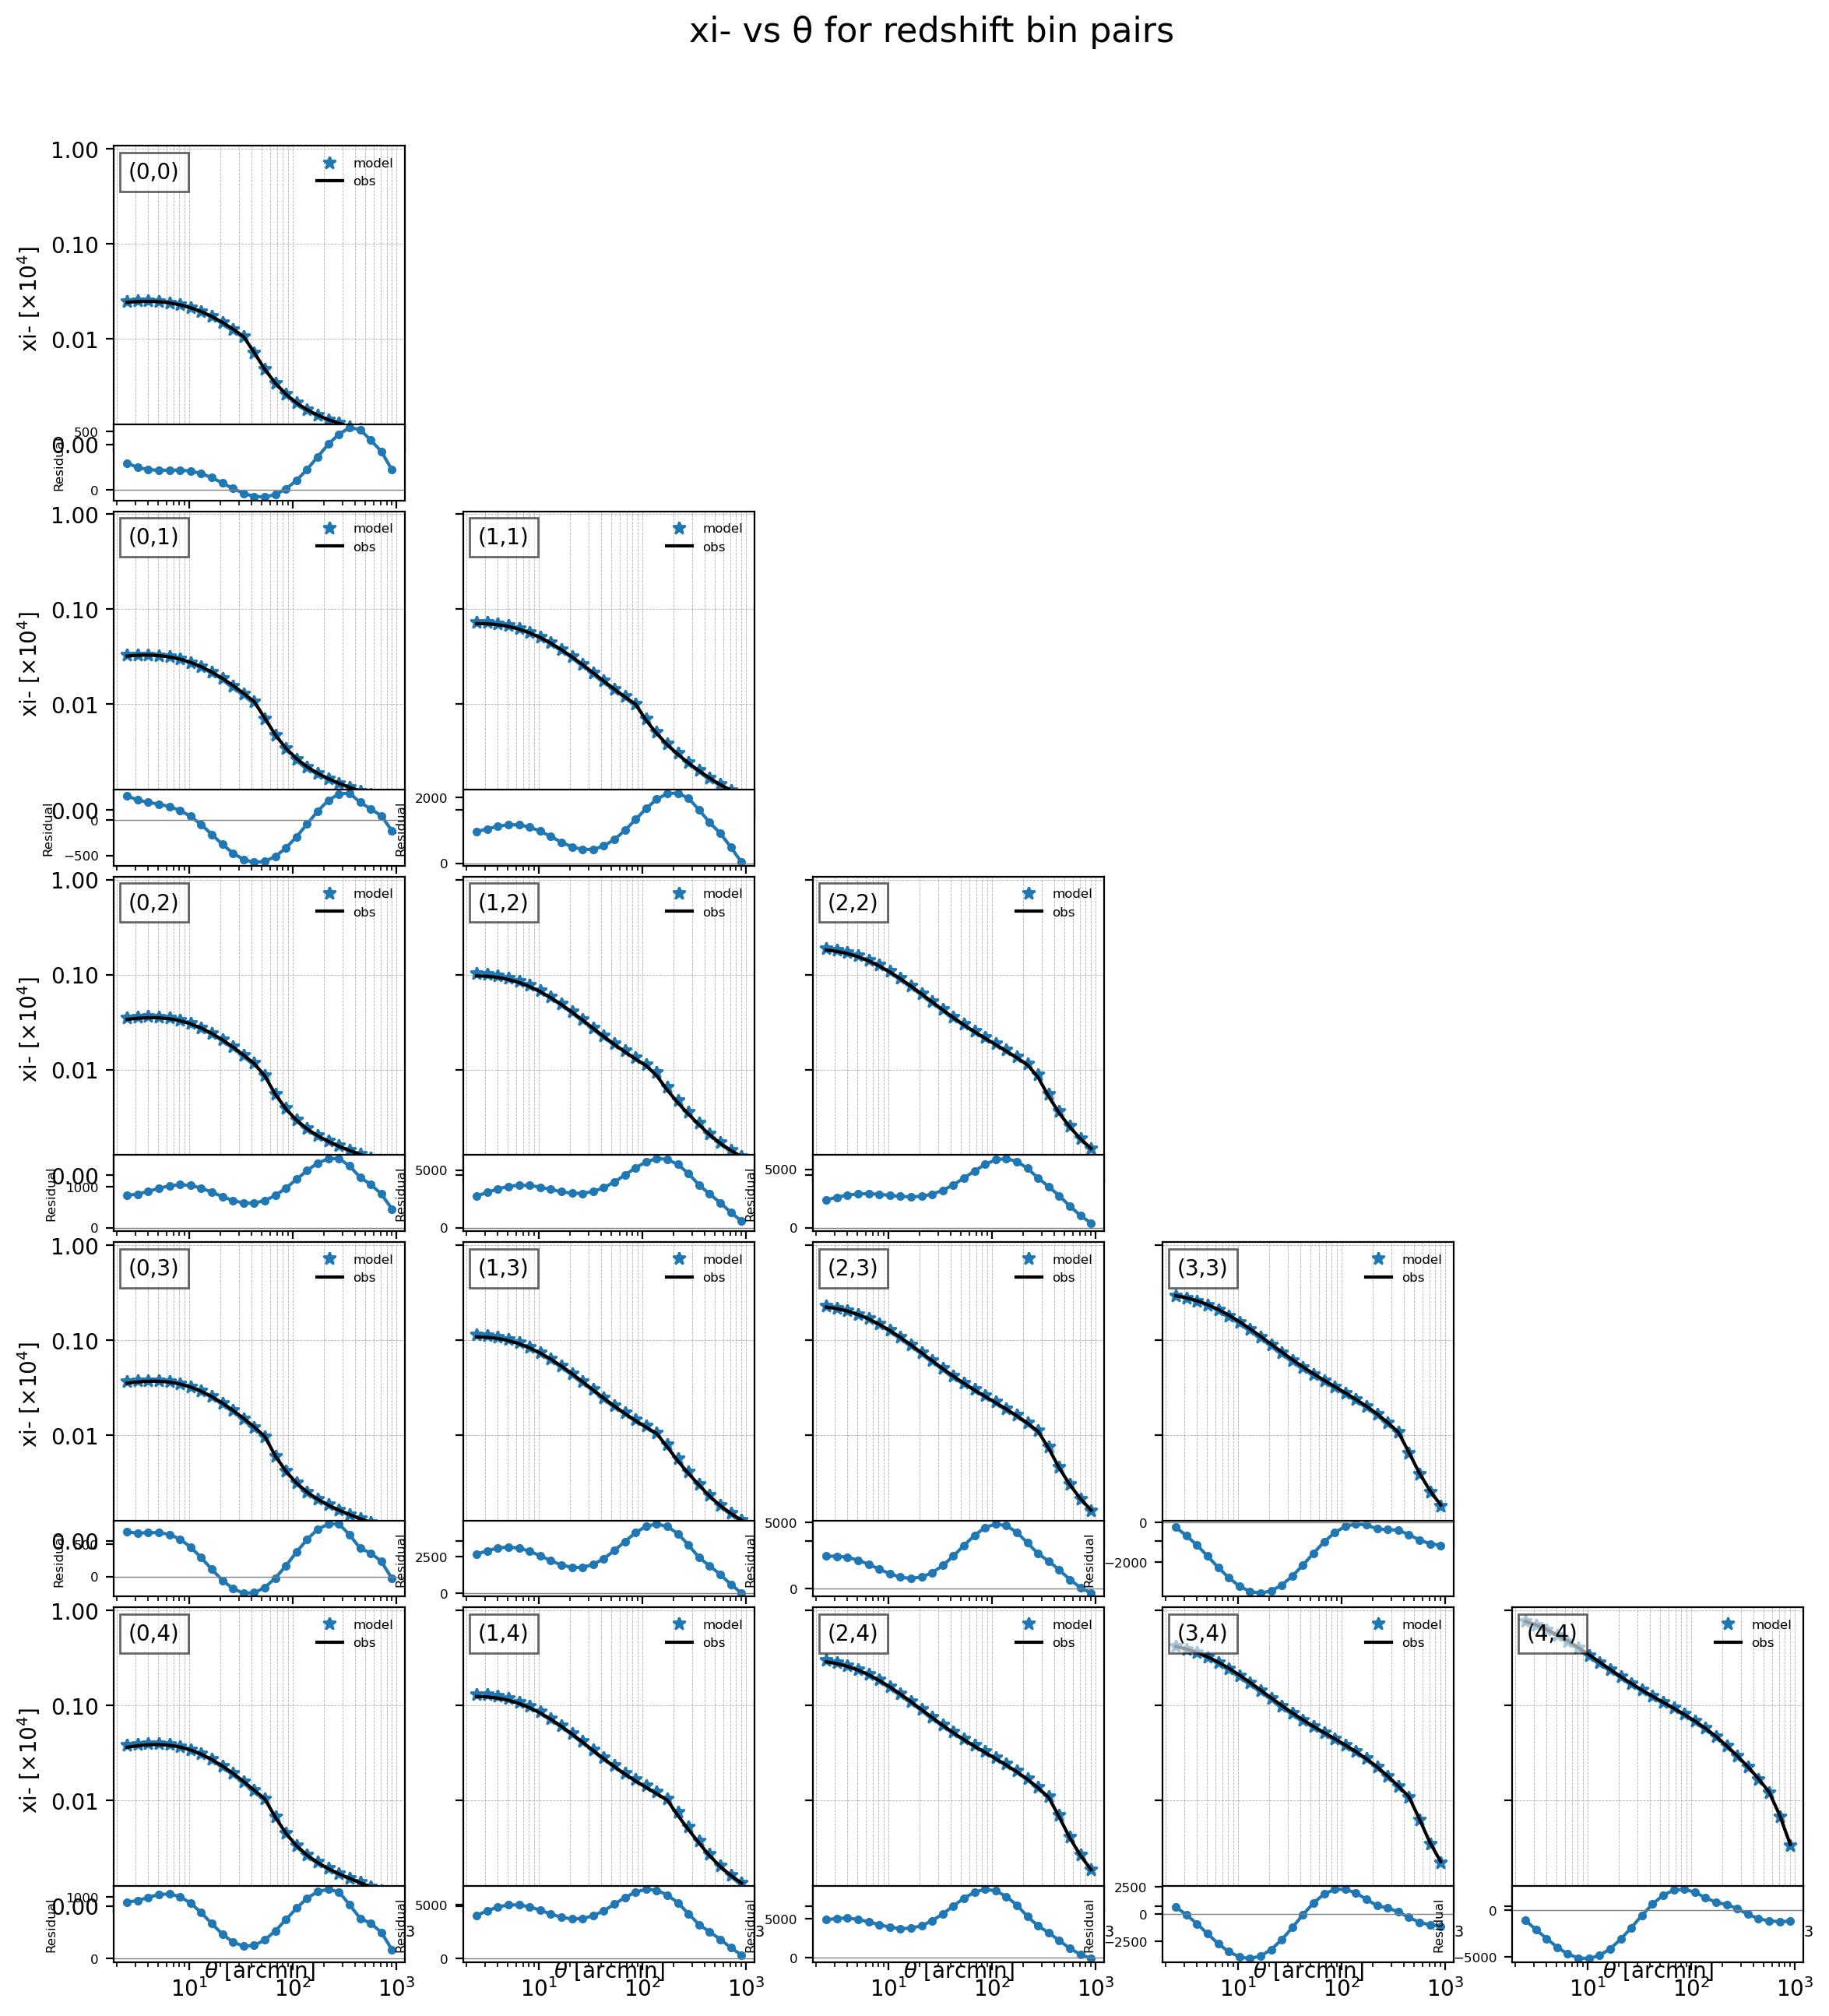

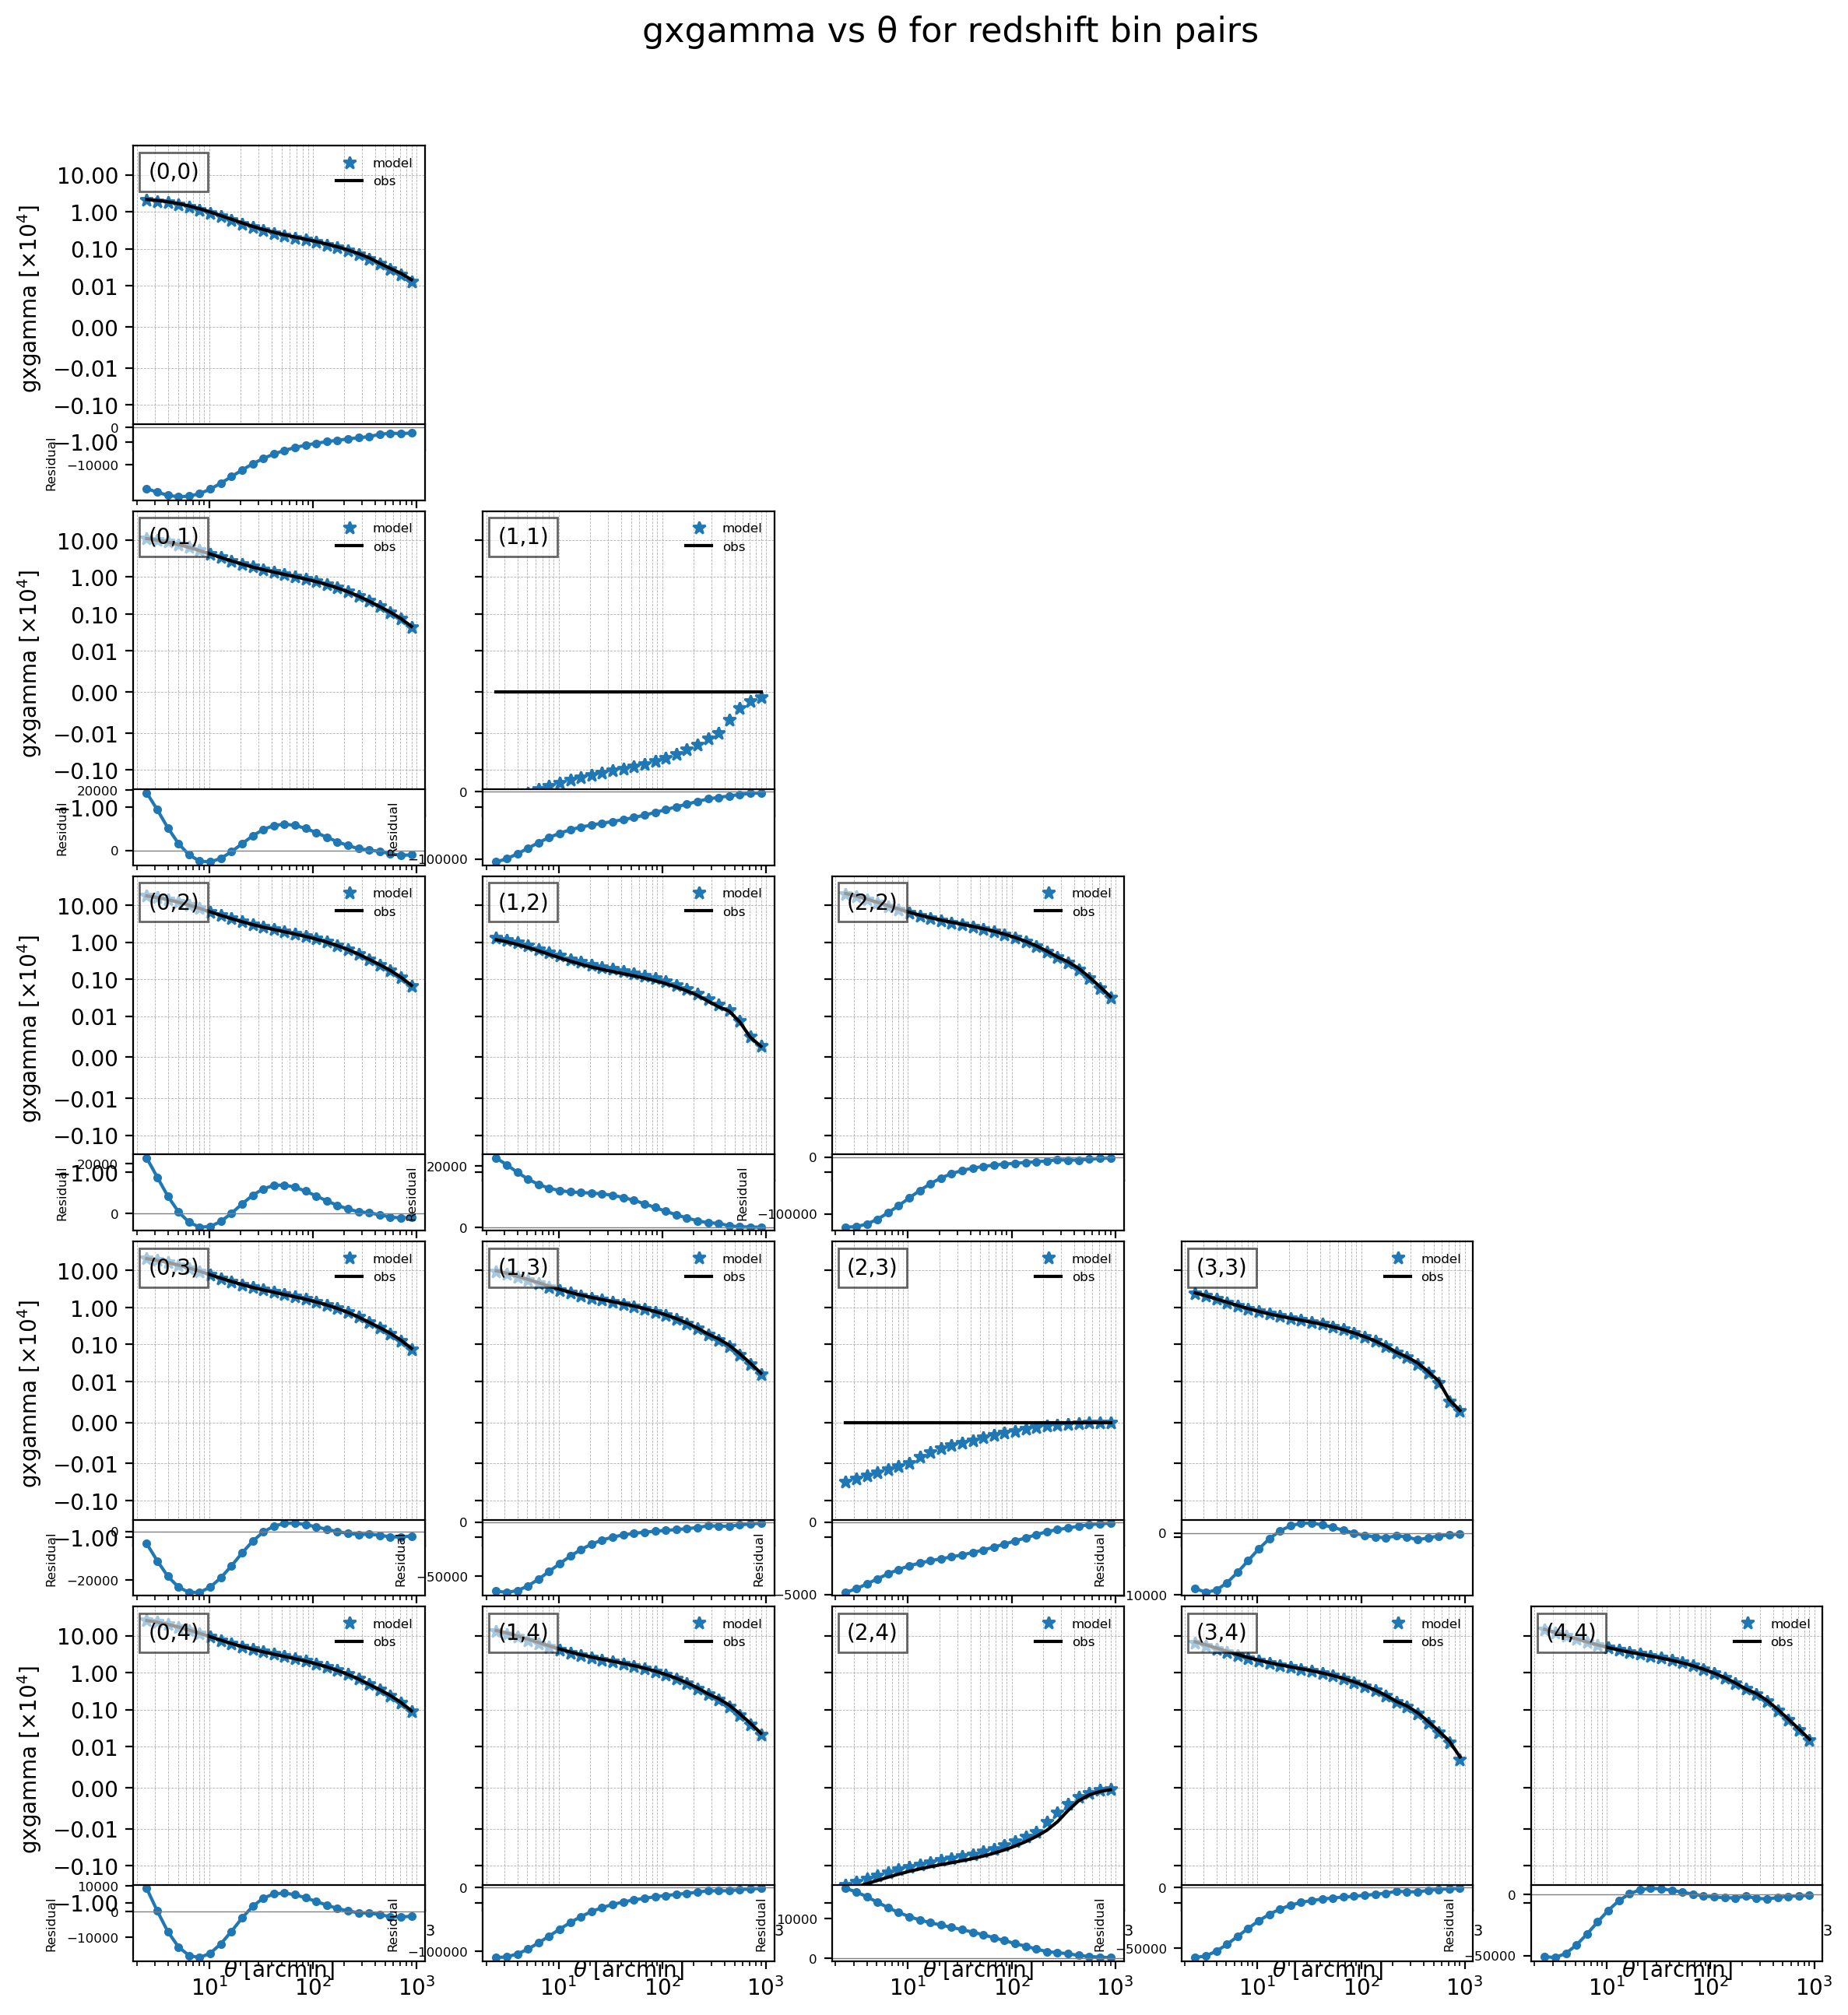

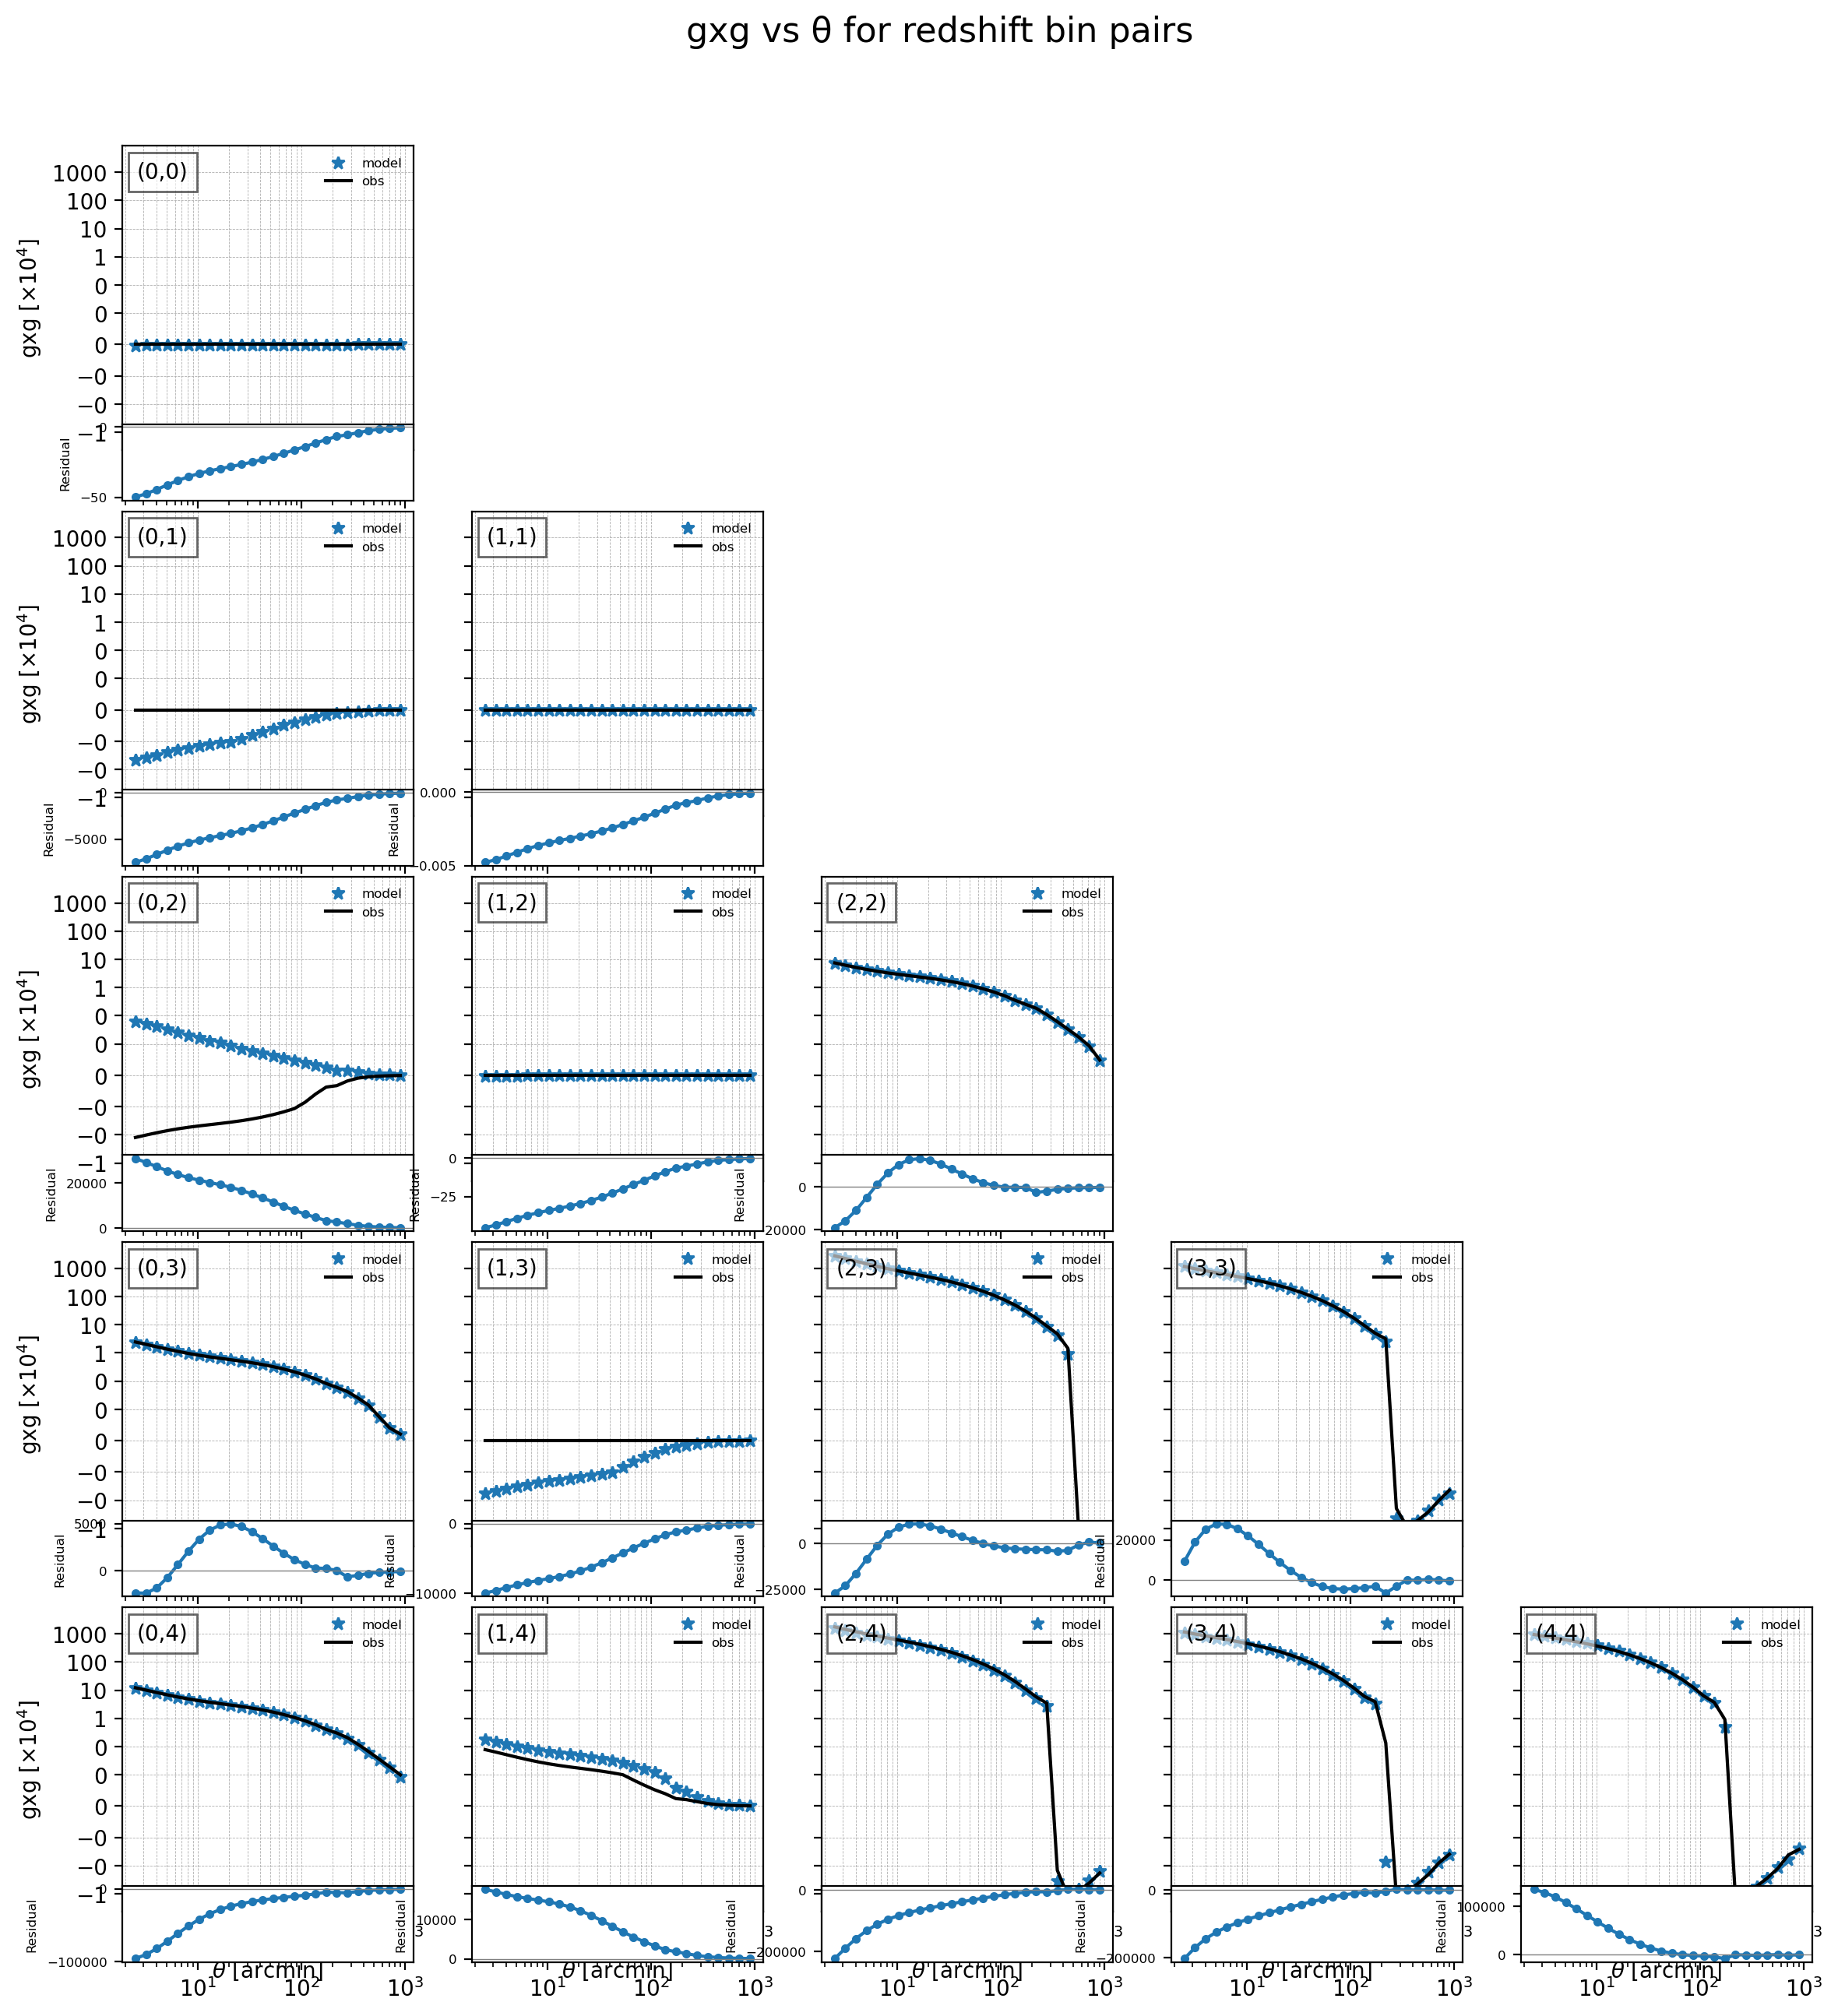

In [7]:
plot_all_observables_triangle(unmasked_model_datavector, obs_datavector, C_1, C_2)

/home/junzhou/ipykernel_459486/3966423632.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(C_1))
/home/junzhou/ipykernel_459486/3966423632.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(C_1))


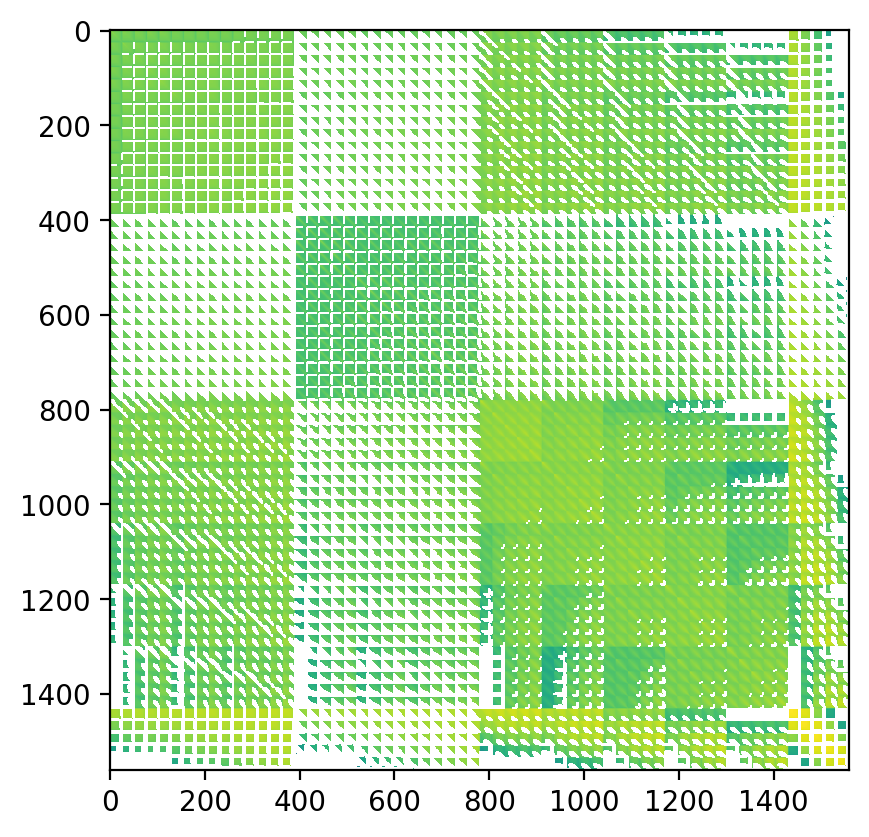

In [11]:
plt.imshow(np.log(C_1))